In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../")

In [4]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter_train_val_test

In [5]:
from DataSets import UNetDatasetFromFolders

In [6]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [7]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [8]:
model_name = "../model/trained_cUNet_pytorch_regression_complete_dataset_250epochs_coeff_mask0.75_validation.pkl"

In [9]:
model_inference = cUNet(out_size=1)

In [10]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
root_folder = os.path.join(data_dir, "dataset")

In [13]:
composed = transforms.Compose([Cut(), Rescale(.25), ChannelsFirst(), ToTensor()])

In [14]:
complete_dataset = UNetDatasetFromFolders(root_folder, transform=composed)

In [15]:
data_loaders, data_lengths = splitter_train_val_test(complete_dataset,
                                                    validation_split=0.2,
                                                    test_split=0.2,
                                                    batch=16,
                                                    workers=4)

In [16]:
data_lengths

{'train': 5717, 'val': 1429, 'test': 1786}

In [17]:
model_inference.eval()
model_inference.to(device);

batch 1
1: true_dist: 25, pred_dist: [24.975834]


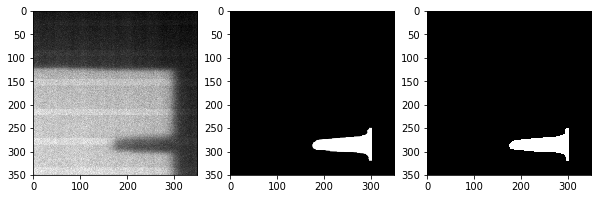

2: true_dist: 2, pred_dist: [2.033003]


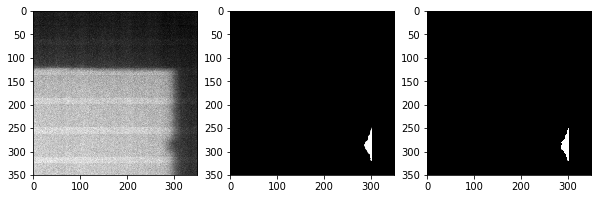

3: true_dist: 35, pred_dist: [34.984505]


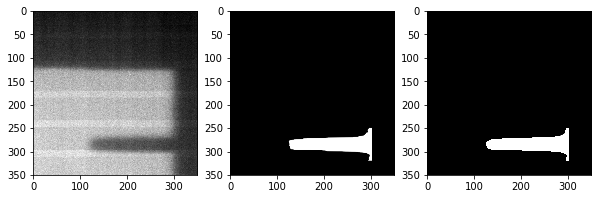

4: true_dist: 30, pred_dist: [29.97942]


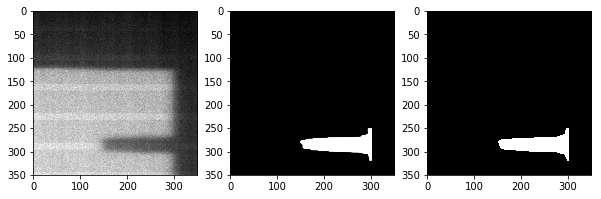

5: true_dist: 2, pred_dist: [2.0305977]


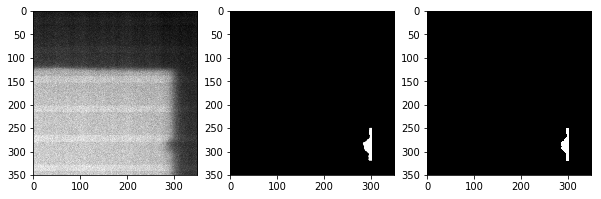

6: true_dist: 25, pred_dist: [24.979902]


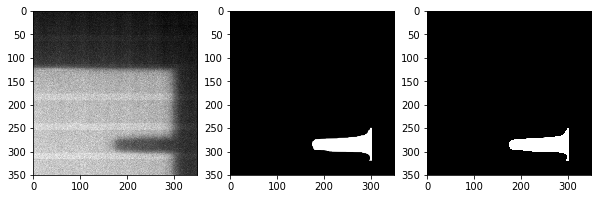

7: true_dist: 10, pred_dist: [9.984722]


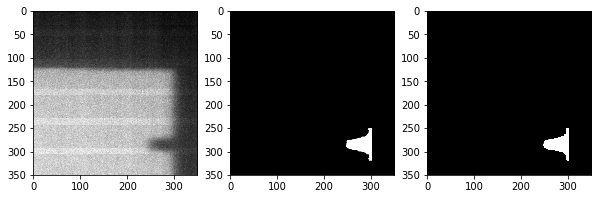

8: true_dist: 3, pred_dist: [2.998077]


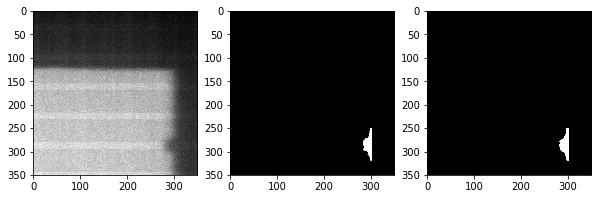

9: true_dist: 15, pred_dist: [14.986865]


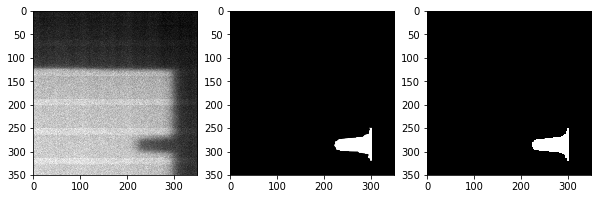

10: true_dist: 2, pred_dist: [2.0161068]


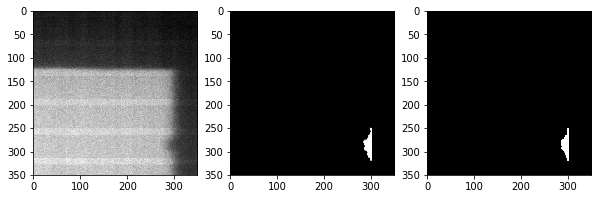

11: true_dist: 3, pred_dist: [2.992036]


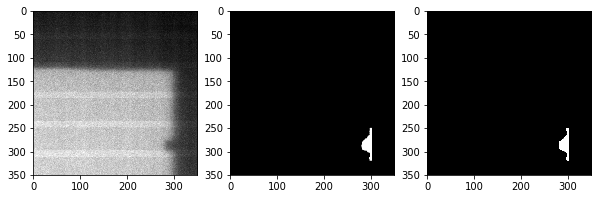

12: true_dist: 35, pred_dist: [34.950672]


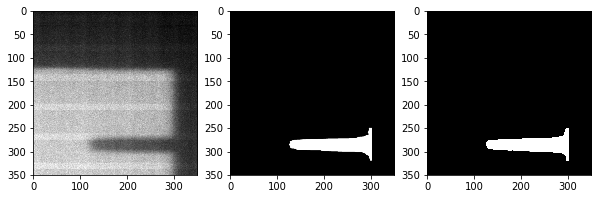

13: true_dist: 2, pred_dist: [2.013958]


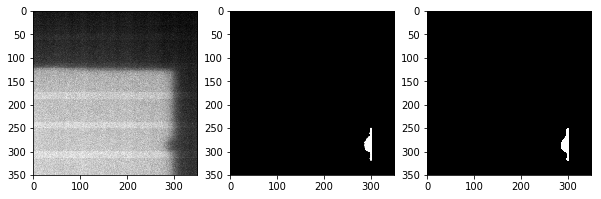

14: true_dist: 10, pred_dist: [9.979923]


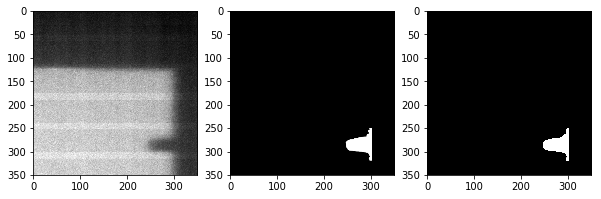

15: true_dist: 20, pred_dist: [19.970745]


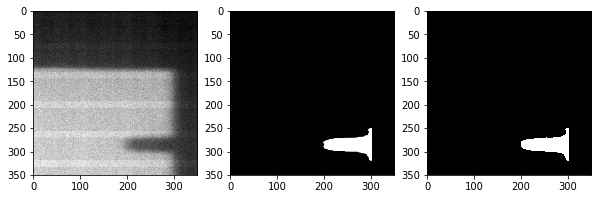

16: true_dist: 1, pred_dist: [1.027088]


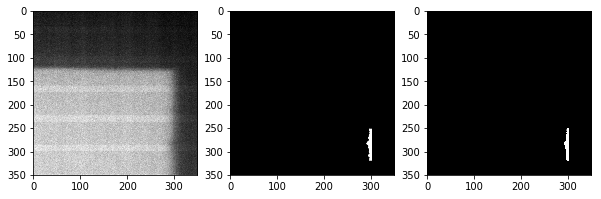

batch 2
1: true_dist: 35, pred_dist: [34.986313]


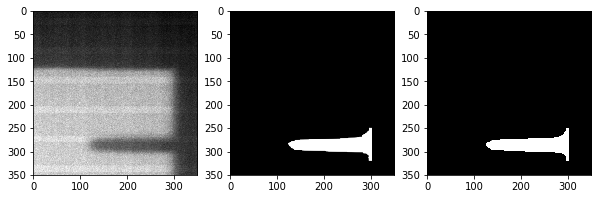

2: true_dist: 10, pred_dist: [9.997358]


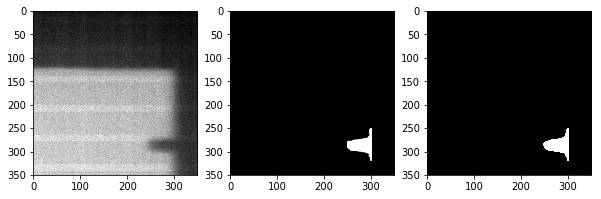

3: true_dist: 25, pred_dist: [24.982052]


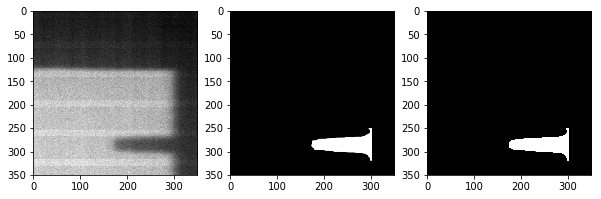

4: true_dist: 4, pred_dist: [3.9901395]


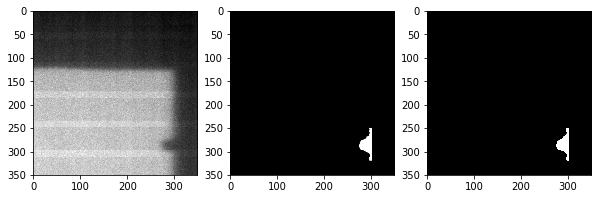

5: true_dist: 20, pred_dist: [19.97834]


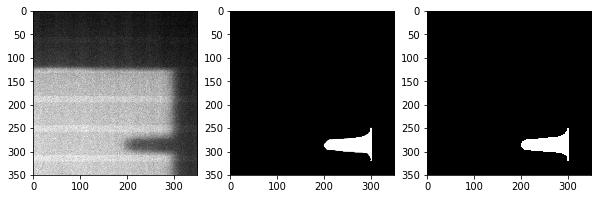

6: true_dist: 25, pred_dist: [24.983824]


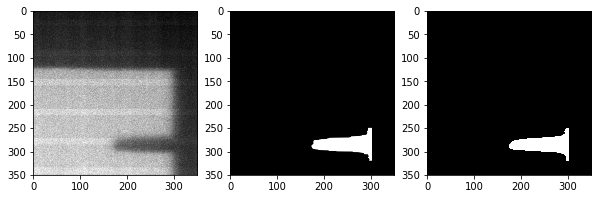

7: true_dist: 20, pred_dist: [19.98496]


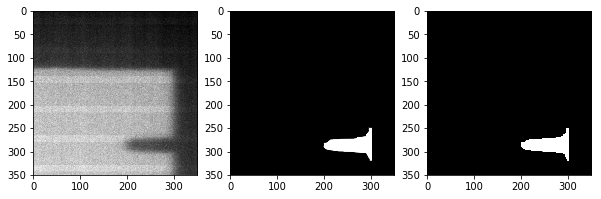

8: true_dist: 10, pred_dist: [9.989036]


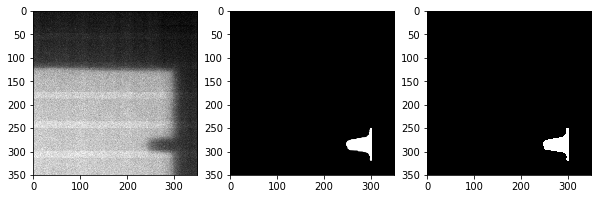

9: true_dist: 20, pred_dist: [19.99108]


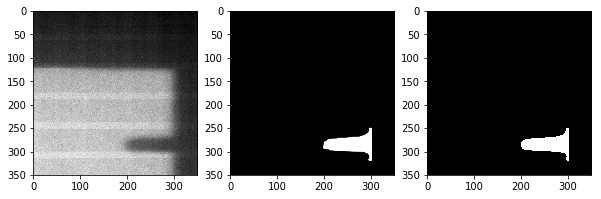

10: true_dist: 10, pred_dist: [9.977139]


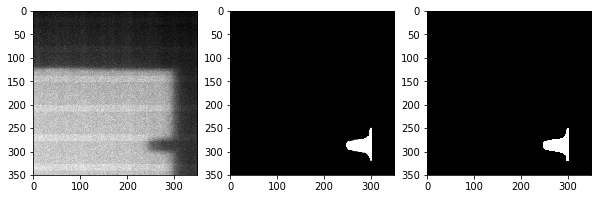

11: true_dist: 1, pred_dist: [1.0165106]


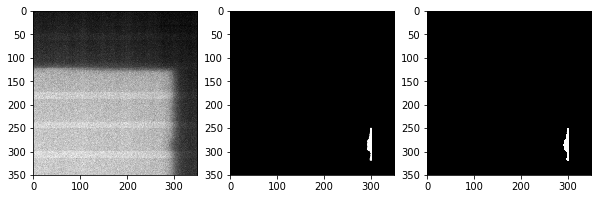

12: true_dist: 1, pred_dist: [0.99943835]


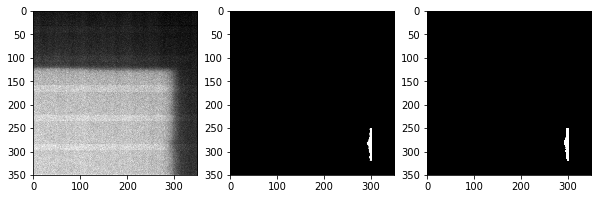

13: true_dist: 10, pred_dist: [10.011514]


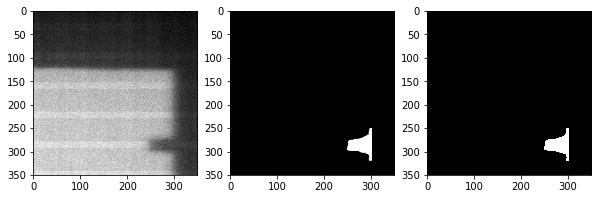

14: true_dist: 25, pred_dist: [24.978817]


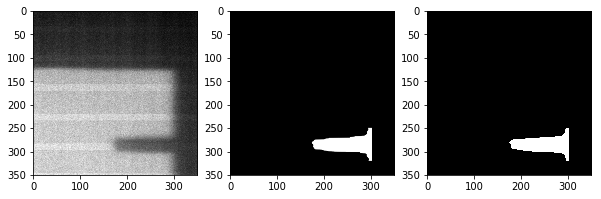

15: true_dist: 3, pred_dist: [3.0100367]


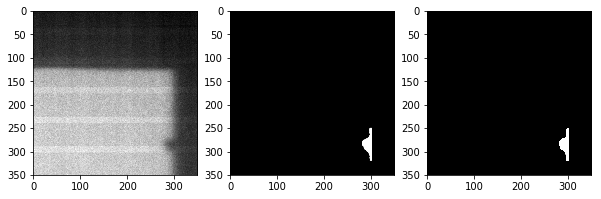

16: true_dist: 25, pred_dist: [24.979994]


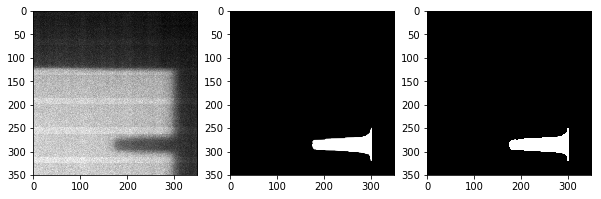

In [18]:
for i, batch in enumerate(data_loaders['test']):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_dists = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_dist, pr_msk, pr_dist) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_dists.cpu().detach().numpy())):
    
        true_dist = tr_dist
        pred_dist = pr_dist
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [18]:
batch_size=16

In [19]:
y_true = []
y_pred = []

for i, batch in tqdm(enumerate(data_loaders['test']), total = data_lengths['test']//batch_size, desc = "Mini Batch"):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_dists = model_inference(true_images.float().to(device))
#    print("batch {}".format(i + 1))
    for j, (img, tr_dist, pr_dist) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_dists.cpu().detach().numpy())):
        true_dist = tr_dist
        pred_dist = pr_dist
        y_true.append(true_dist)
        y_pred.append(pred_dist)




In [20]:
y_pred = np.asarray(y_pred).ravel()
y_true = np.asarray(y_true)

print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 0.0003184520297565017


In [21]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [22]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [23]:
idx_1, mse_1 = idx_mse(1)
idx_2, mse_2 = idx_mse(2)
idx_3, mse_3 = idx_mse(3)
idx_4, mse_4 = idx_mse(4)
idx_10, mse_10 = idx_mse(10)
idx_15, mse_15 = idx_mse(15)
idx_20, mse_20 = idx_mse(20)
idx_25, mse_25 = idx_mse(25)
idx_30, mse_30 = idx_mse(30)
idx_35, mse_35 = idx_mse(35)

1 0.00023110089128195105
2 0.0004119085460735112
3 0.00032335880365508274
4 0.00029875636797722547
10 0.0001462391605932449
15 0.0001812277233388945
20 0.0001751818026811882
25 0.0002975952755812908
30 0.0005235303440181933
35 0.0006258582449197479


In [24]:
distances = [1,2,3,4,10,15,20,25,30,35]

In [25]:
errors = [idx_mse(i)[1] for i in distances]

1 0.00023110089128195105
2 0.0004119085460735112
3 0.00032335880365508274
4 0.00029875636797722547
10 0.0001462391605932449
15 0.0001812277233388945
20 0.0001751818026811882
25 0.0002975952755812908
30 0.0005235303440181933
35 0.0006258582449197479


(0, 0.05)

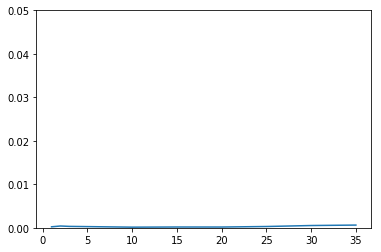

In [26]:
plt.plot(distances, errors)
plt.ylim((0,0.05))

In [27]:
np.savez_compressed("Predicted_ALL_out_model_trained_on_ALLDATA_250_epochs.npz", true=y_true, pred = y_pred)